In [1]:
# Importing the necessary libraries

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set the paths to train, test, and validation folders
train_folder = 'chest_xray/train'
test_folder = 'chest_xray/test'
val_folder = 'chest_xray/val'

# Downsampling the images to 128X128 pixels
downsampled_size = (128, 128)

# Define batch sizes
train_batch_size = 5216
test_batch_size = 624
val_batch_size = 16

# Rescale pixel values between 0 and 1
datagen = ImageDataGenerator(rescale=1./255)  

def load_data(data_dir, batch_size, datagen, downsampled_size, is_train_data):
    try:
        generator = datagen.flow_from_directory(
            data_dir,
            target_size=downsampled_size,
            batch_size=batch_size,
            class_mode='binary',
            shuffle=is_train_data
        )
    except Exception as e:
        raise Exception(f"Error loading data from {data_dir}: {e}") from e
    return generator

# Load the train data
train_generator = load_data(train_folder, train_batch_size, datagen, downsampled_size, True)

# Load the test data
test_generator = load_data(test_folder, test_batch_size, datagen, downsampled_size, False)

# Load the validation data
val_generator = load_data(val_folder, val_batch_size, datagen, downsampled_size, False)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Data Visualization & Preprocessing
### EDA

In [3]:
# Retrieve the dictionary of class indices from the train_generator
dict_class = train_generator.class_indices
print(f'Dictionary: {dict_class}')

# Get the list of class labels
class_names = list(dict_class.keys())
print(f'Class labels: {class_names}')


Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


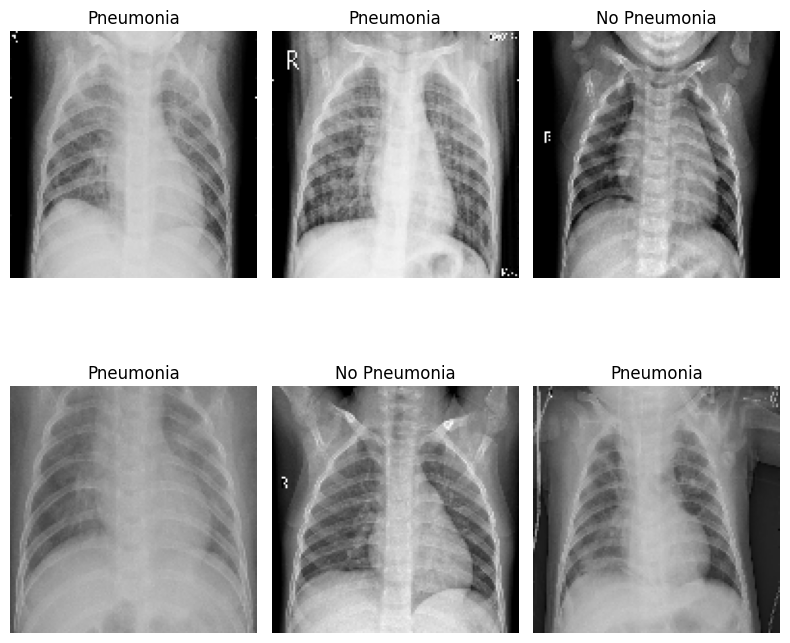

In [4]:
# Get a batch of images and labels from the train_generator
images, labels = next(train_generator)

# Define the number of images to display
num_images = 6

# Create a 2x3 subplot figure with adjusted aspect ratio
fig, axes = plt.subplots(2, 3, figsize=(8, 8), subplot_kw={'aspect': 'auto'})

# Loop over the first few images
for i in range(min(num_images, len(images))):
    # Display the image
    axes[i//3, i%3].imshow(images[i], cmap='gray')  # Assuming grayscale images
    # Set the title to the corresponding label
    if labels[i] == 0:
        axes[i//3, i%3].set_title('No Pneumonia')
    else:
        axes[i//3, i%3].set_title('Pneumonia')
    # Remove the axis
    axes[i//3, i%3].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


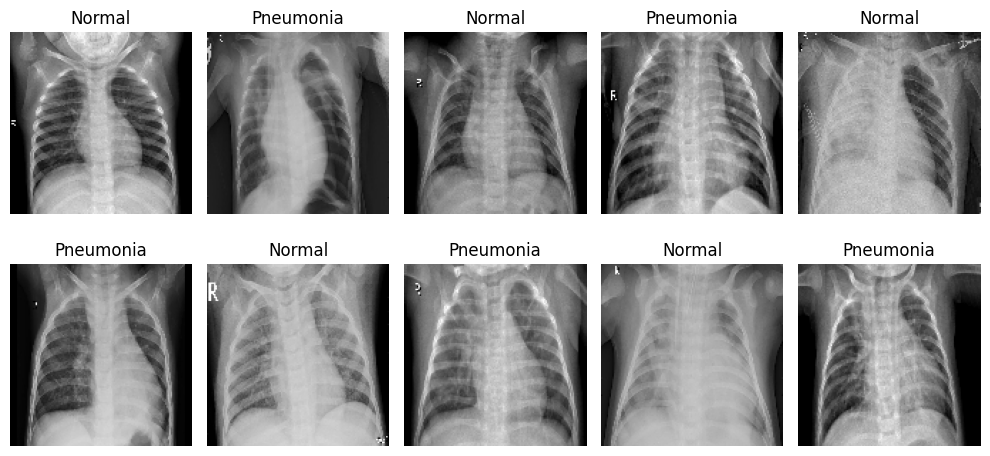

In [5]:
# Define the number of images to display
num_images = 10

# Create a 2x5 subplot figure with adjusted aspect ratio
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

# Get a batch of 'Normal' and 'Pneumonia' images
normal_images, _ = train_generator.next()
pneumonia_images, _ = train_generator.next()

# Loop over the first few images
for i in range(min(num_images, len(normal_images), len(pneumonia_images))):
    # Display the image
    if i % 2 == 0:
        axes[i].imshow(normal_images[i], cmap='gray')
        axes[i].set_title('Normal')
    else:
        axes[i].imshow(pneumonia_images[i], cmap='gray')
        axes[i].set_title('Pneumonia')
    # Remove the axis
    axes[i].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

In [6]:
def visualize_class_distributions(train_generator, test_generator, val_generator, class_names):
    """
    Visualizes the class distributions for the training, test, and validation data.
    
    Args:
        train_generator (ImageDataGenerator): The training data generator.
        test_generator (ImageDataGenerator): The test data generator.
        val_generator (ImageDataGenerator): The validation data generator.
        class_names (list): The list of class names.
    """
    # Count the occurrences of each class in the training data
    train_class_counts = np.bincount(train_generator.classes)
    
    # Count the occurrences of each class in the test data
    test_class_counts = np.bincount(test_generator.classes)
    
    # Count the occurrences of each class in the validation data
    val_class_counts = np.bincount(val_generator.classes)
    
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot the training data class distribution
    ax1.bar(class_names, train_class_counts)
    ax1.set_title('Training Data Class Distribution')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Count')
    
    # Plot the test data class distribution
    ax2.bar(class_names, test_class_counts)
    ax2.set_title('Test Data Class Distribution')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Count')
    
    # Plot the validation data class distribution
    ax3.bar(class_names, val_class_counts)
    ax3.set_title('Validation Data Class Distribution')
    ax3.set_xlabel('Class')
    ax3.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

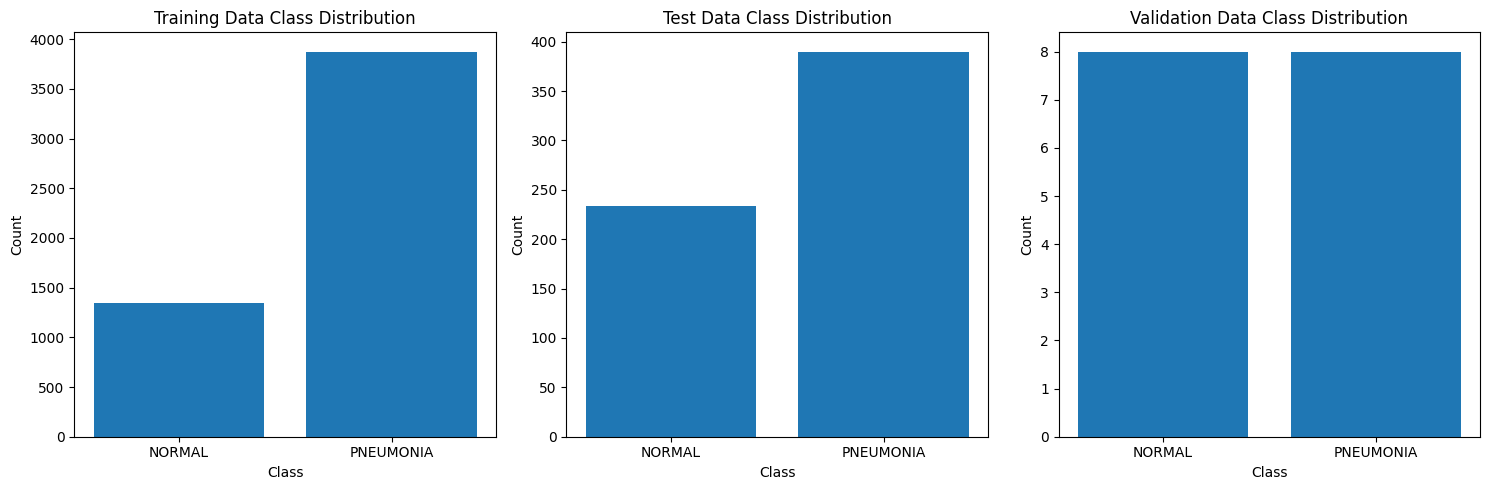

In [7]:
# Call the function with your data generators and class names
visualize_class_distributions(train_generator, test_generator, val_generator, class_names)

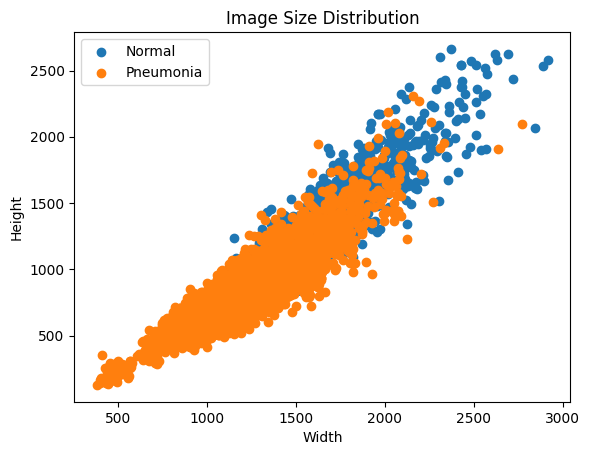

In [13]:
from PIL import Image
normal_image_sizes = []
pneumonia_image_sizes = []
for image_path in train_generator.filepaths:
    img = Image.open(image_path)
    width, height = img.size
    if "NORMAL" in image_path:
        normal_image_sizes.append((width, height))
    else:
        pneumonia_image_sizes.append((width, height))
normal_image_sizes = np.array(normal_image_sizes)
pneumonia_image_sizes = np.array(pneumonia_image_sizes)
plt.scatter(normal_image_sizes[:, 0], normal_image_sizes[:, 1], label='Normal')
plt.scatter(pneumonia_image_sizes[:, 0], pneumonia_image_sizes[:, 1], label='Pneumonia')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

### Data Preprocessing

In [16]:
# Obtain images and labels
train_images, train_labels = get_images_and_labels(train_generator)
test_images, test_labels = get_images_and_labels(test_generator)
val_images, val_labels = get_images_and_labels(val_generator)

In [17]:
def get_images_and_labels(generator):
    # Obtain images and labels from the generator
    images, labels = next(generator)
    return images, labels

def print_dataset_info(images, labels, dataset_type):
    # Print the shape of the images and labels
    m = images.shape[0]
    num_px = images.shape[1]
    print(f"Number of {dataset_type} samples: {m}")
    print(f"{dataset_type}_images shape: {images.shape}")
    print(f"{dataset_type}_labels shape: {labels.shape}")

# Print dataset information
print_dataset_info(train_images, train_labels, "training")
print_dataset_info(test_images, test_labels, "testing")
print_dataset_info(val_images, val_labels, "validation")


Number of training samples: 5216
training_images shape: (5216, 128, 128, 3)
training_labels shape: (5216,)
Number of testing samples: 624
testing_images shape: (624, 128, 128, 3)
testing_labels shape: (624,)
Number of validation samples: 16
validation_images shape: (16, 128, 128, 3)
validation_labels shape: (16,)


In [18]:
# Reshape the image arrays
train_images_flatten = train_images.reshape(train_images.shape[0], -1)
test_images_flatten = test_images.reshape(test_images.shape[0], -1)
val_images_flatten = val_images.reshape(val_images.shape[0], -1)

# Print the shape of the arrays after reshaping
print ("train_images_flatten shape: " + str(train_images_flatten.shape))
print ("test_images_flatten shape: " + str(test_images_flatten.shape))
print ("val_images_flatten shape: " + str(val_images_flatten.shape))


train_images_flatten shape: (5216, 49152)
test_images_flatten shape: (624, 49152)
val_images_flatten shape: (16, 49152)


### Modelling

#### Baseline Mode


In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Add a pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add an output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


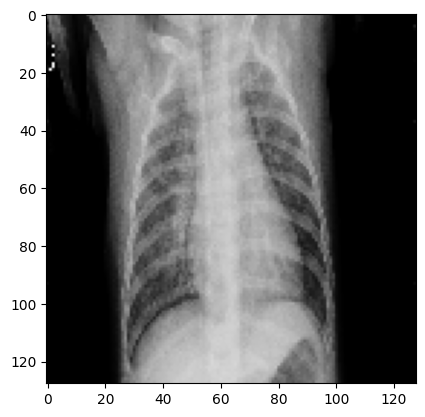

In [20]:
import matplotlib.pyplot as plt

# Assuming train_images is your training images
plt.imshow(train_images[0])
plt.show()


In [21]:
# Assuming results_1 is the history object from your model training
plt.plot(results_1.history['accuracy'])
plt.plot(results_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


NameError: name 'results_1' is not defined